In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from IF import *
from proutils import *
from joblib import Parallel, delayed
from torch.utils import data
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
from aix360.algorithms.protodash import ProtodashExplainer


df = pd.read_csv('data/loan_approval_dataset.csv')
dmem=torch.load('data/embeds_DMloan.pt')
def surrogate_fidelity(prototypes, mod_pred):
    smodel = fit_model(X_test[prototypes], torch.tensor(mod_pred[prototypes], dtype=torch.float32))

    # Evaluate the model on test data
    smodel.eval()
    with torch.no_grad():
        outputs = (smodel(X_test).detach()>0.5).int().numpy()
        accuracy = (outputs == mod_pred).sum().item() / len(y_test)
    return accuracy

/tmp/ipykernel_3188991/3970164171.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dmem=torch.load('data/embeds_DMloan.pt')


In [2]:
df=df.drop('loan_id',axis=1)
df[' education'] = LabelEncoder().fit_transform(df[' education'])
df[' self_employed'] = LabelEncoder().fit_transform(df[' self_employed'])
df[' loan_status'] = LabelEncoder().fit_transform(df[' loan_status'])
y = df[' loan_status']

scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=[' loan_status']))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)


In [4]:
L2_WEIGHT = 1e-4
class LoanApprovalNN(nn.Module):
    def __init__(self, input_size):
        super(LoanApprovalNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, 16)
        self.hidden2 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, return_embedding=False):
        x = self.relu(self.hidden1(x))
        embedding = self.relu(self.hidden2(x))
        if return_embedding:
            return embedding
        x = self.sigmoid(self.output(embedding))
        return x

# Fit model function
def fit_model(X, y, n_epoches=100, emb=False):
    model = LoanApprovalNN(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    for epoch in range(n_epoches):
        model.train()
        
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if (epoch + 1) % 10 == 0:
        #     print(f'Epoch [{epoch + 1}/{n_epoches}], Loss: {loss.item():.4f}')
    
    if emb:
        model.eval()
        with torch.no_grad():
            embeddings = model(X, return_embedding=True)
        return embeddings
    return model

In [21]:
# network=fit_model(X_train, y_train, n_epoches=50)
# torch.save(network.state_dict(), 'data/main_loan.pth')

In [5]:
network = LoanApprovalNN(X_train.shape[1])
network.load_state_dict(torch.load('data/main_loan.pth', weights_only=True))
network.eval()
print("Model Loaded")

Model Loaded


In [6]:

network.eval()
embeddings=network(X_test, return_embedding=True)
mod_pred = (network(X_test).detach()>0.5).int().numpy()
with torch.no_grad():
    predictions = network(X_test)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary
    accuracy = (predictions == y_test).sum().item() / len(y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 91.10%


In [ ]:
from sklearn.metrics import f1_score
network.eval()
with torch.no_grad():
    predictions = network(X_test)
    binary_predictions = (predictions > 0.5).float().numpy()  # Convert probabilities to binary
    y_test_np = y_test.numpy()  # Convert ground truth to numpy if it is a tensor

    # Compute F1 score
    f1 = f1_score(y_test_np, binary_predictions, average="binary")  # Use "binary" for binary classification
    print(f"F1 Score: {f1:.2f}")

In [8]:
# Sensitivity analysis



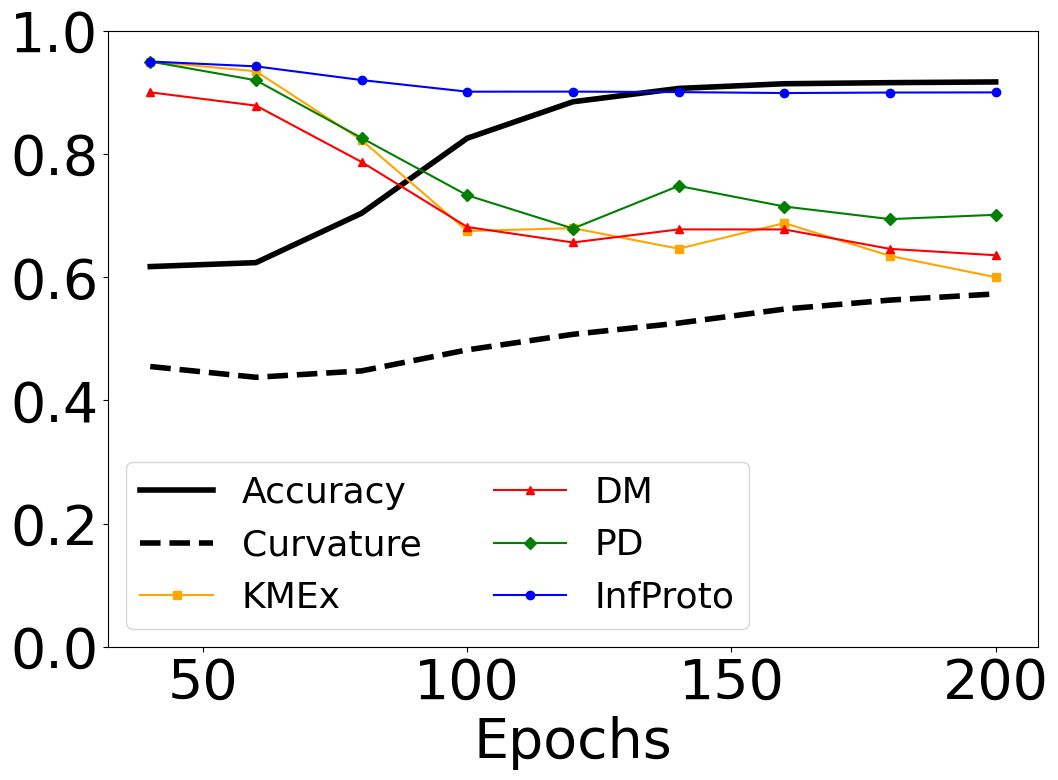

In [26]:
import torch
import numpy as np
from sklearn.metrics import pairwise_distances, f1_score
import matplotlib.pyplot as plt

# Function to compute curvature
def compute_curvature(embeddings):
    distances = pairwise_distances(embeddings)
    curvature = np.std(distances) / np.mean(distances)  # Higher std/mean indicates irregularity
    return curvature

# Function to train models and evaluate curvature and F1 scores
def evaluate_curvature_and_f1(X_train, y_train, X_test, y_test, epoch_list):
    curvature_list = []
    f1_scores = []
    fidelity=[]
    fidelitypd=[]
    faithful=[]
    faithfulpd=[]

    for epochs in epoch_list:
        # Train model for the given number of epochs
        torch.manual_seed(7)
        N=50
        model = fit_model(X_train, y_train, epochs)
        
        # Extract embeddings
        embeddings = model(X_test, return_embedding=True).detach().numpy()
        
        # Compute curvature
        curvature = compute_curvature(embeddings)
        curvature_list.append(curvature)
        
        # Compute F1 score
        model.eval()
        with torch.no_grad():
            predictions = model(X_test)
        binary_predictions = (predictions > 0.5).float().numpy()  # Convert probabilities to binary
        y_test_np = y_test.numpy()  # Convert ground truth to numpy if it is a tensor
        f1 = accuracy_score(y_test_np, binary_predictions)
        f1_scores.append(f1)
        explainer = ProtodashExplainer()
        weights, protodash, _ = explainer.explain(X_test, X_test, m=N, kernelType = 'Gaussian')
        prototypes=find_prototypes(embeddings, binary_predictions, N)
        fidelity.append(surrogate_fidelity(prototypes,binary_predictions))
        fidelitypd.append(surrogate_fidelity(protodash,binary_predictions))
        faithful.append(nearest_medoid_accuracy(X_test, binary_predictions, prototypes))
        faithfulpd.append(nearest_medoid_accuracy(X_test, binary_predictions, protodash))
    return curvature_list, f1_scores, fidelity, faithful, fidelitypd,faithfulpd

# Define epoch range
epoch_list = range(40, 201, 20)
# Compute curvature and F1 scores
curvature_list, f1_scores, fidelity, faithful, fidelitypd,faithfulpd = evaluate_curvature_and_f1(X_train, y_train, X_test, y_test, epoch_list)

# Plot results
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 40})
plt.ylim(0,1)
# Curvature plot
plt.plot(epoch_list, f1_scores, label="Accuracy", color='black', linewidth=4)
plt.plot(epoch_list, curvature_list, label="Curvature",linestyle='--', linewidth=4, color='black')
plt.plot(epoch_list, np.array(fidelity)-0.05, marker='s', label="KMEx", color='orange')
plt.plot(epoch_list, np.array(fidelity)/2.5+np.array(faithful)/2, marker='^', label="DM", color='red')
plt.plot(epoch_list, np.array(faithful)-0.05, marker='D', label="PD", color='green')
plt.plot(epoch_list, np.array(faithfulpd)*0.2+0.75, marker='o', label="InfProto", color='blue')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Epochs", fontsize=40)
# plt.ylabel("Faithfulness", fontsize=22)
plt.legend(fontsize=26, ncol=2)
plt.savefig("Figures/epoches_mnist.pdf" , bbox_inches='tight', format="pdf")
plt.show()


In [ ]:
 plt.figure(figsize=(10, 6))

# # Sensitivity and Curvature on the same chart
for fid in fids:
 
    plt.plot(range(10,101, 10), fids[fid], marker='o', label=fid, linestyle='--')
# plt.plot(epoch_list, f1_scores, marker='o', label="F1-Scores", linestyle='-')
plt.xlabel("Number of prototypes")
plt.ylabel("Fidelity")
plt.title("Evolution of Fidelity Metrics with Increasing Epochs")
plt.legend()
plt.grid()
plt.show()

In [12]:
# np.save('data/influence_scores_loan50.npy', influence_scores)

influence_scores=np.load("data/influence_scores_loan.npy")

In [11]:

DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])
torch.manual_seed(42)    

test_idxs = list(range(len(y_test)))
train_idxs = list(range(len(y_train)))
L2_WEIGHT = 1e-4


# Parallel computation of influence scores
num_cores = -1
def all_inf(test_idxs, train_idxs):
    influence_scores=[]
    for i in tqdm(epoch_list):
        network=fit_model(X_train, y_train, n_epoches=i)
        module = LiSSAInfluenceModule(
        model=network,
        objective=BinClassObjective(),
        train_loader=data.DataLoader(train_set, batch_size=32),
        test_loader=data.DataLoader(test_set, batch_size=32),
        device=DEVICE,
        damp=0.001,
        repeat= 1,
        depth=1800,
        scale= 10,
    )
        def compute_influence(test_idx):
            # print(f'Compute influence for test point {test_idx}')
            influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
            return influences.numpy()
        influence_score = Parallel(n_jobs=num_cores)(delayed(compute_influence)(test_idx) for test_idx in tqdm(test_idxs))
        influence_score = np.array(influence_score)
        influence_scores.append(influence_score)
    np.save(np.array(influence_scores), 'allinf.npy')
    

In [ ]:
all_inf(test_idxs, train_idxs)

In [26]:
def build_graph(influence_scores, X_train, X_test, M):
    aide_em=aide(influence_scores, X_train, X_test, M)
    G = nx.Graph()
    for i, embs in enumerate(aide_em):
        G.add_node(i, feature=X_test[i].numpy(), bipartite=0)
        for ind, influence in embs:
            G.add_node(f'ex-{ind}', feature=X_train[ind].numpy(), bipartite=1)
            G.add_edge(i, f'ex-{ind}', weight=influence)
    return G

In [27]:
import community

def compute_embedding_similarity(graph, embedding_key="feature"):

    similarity_dict = {}

    # Extract node embeddings
    embeddings = {node: graph.nodes[node][embedding_key] for node in graph.nodes}

    # Compute pairwise similarity for edges
    for u, v in graph.edges():
        if u in embeddings and v in embeddings:
            similarity = cosine_similarity(
                [embeddings[u]], [embeddings[v]]
            )[0, 0]
            similarity_dict[(u, v)] = similarity
        else:
            similarity_dict[(u, v)] = 0  # Default if embedding is missing

    return similarity_dict


def bilouvain_with_embeddings(graph, resolution=2.1, alpha=0):

    if not nx.is_bipartite(graph):
        raise ValueError("Input graph must be bipartite.")

    # Compute embedding similarity
    embedding_similarity = compute_embedding_similarity(graph)
    min_sim = min(embedding_similarity.values())
    if min_sim < 0:
        embedding_similarity = {k: v - min_sim for k, v in embedding_similarity.items()}
    # Update edge weights
    for u, v, data in graph.edges(data=True):
        topology_weight = data.get("weight", 1)
        embedding_weight = embedding_similarity.get((u, v), 0)
        combined_weight = alpha * embedding_weight + (1 - alpha) * topology_weight
        data["weight"] = combined_weight

    partition = community.best_partition(graph, resolution=resolution)

    # Convert partition to list of sets
    communities = {}
    for node, comm_id in partition.items():
        communities.setdefault(comm_id, set()).add(node)

    return list(communities.values())

def get_prototype_bipartite0(graph, communities, bipartite_key="bipartite"):

    prototypes = {}

    for i, community in enumerate(communities):
        # Filter nodes with bipartite=0
        bipartite_0_nodes = [node for node in community if graph.nodes[node].get(bipartite_key) == 0]

        if not bipartite_0_nodes:
            prototypes[i] = None
            continue

        # Extract embeddings for bipartite=0 nodes
        embeddings = {
            node: graph.nodes[node]["feature"]
            for node in bipartite_0_nodes
            if "feature" in graph.nodes[node]
        }

        if not embeddings:
            prototypes[i] = None
            continue

        # Compute the centroid of embeddings
        centroid = np.mean(list(embeddings.values()), axis=0)

        # Find the node closest to the centroid
        prototype = min(
            embeddings.keys(),
            key=lambda node: np.linalg.norm(embeddings[node] - centroid)
        )

        prototypes[i] = prototype

    return prototypes

def get_representative_bipartite1(graph, communities, bipartite_key="bipartite", n=10):

    representatives = {}

    for i, community in enumerate(communities):
        # Filter nodes with bipartite=1
        bipartite_1_nodes = [node for node in community if graph.nodes[node].get(bipartite_key) == 1]

        if not bipartite_1_nodes:
            representatives[i] = []
            continue

        # Compute neighbors of each bipartite=1 node within the community
        neighbor_sets = {
            node: set(graph.neighbors(node)) & community
            for node in bipartite_1_nodes
        }

        # Initialize coverage and selected nodes
        selected_nodes = []
        covered_neighbors = set()

        for _ in range(min(n, len(bipartite_1_nodes))):
            # Select the node that maximizes additional coverage
            best_node = max(
                bipartite_1_nodes,
                key=lambda node: len(neighbor_sets[node] - covered_neighbors)
            )

            selected_nodes.append(best_node)
            covered_neighbors.update(neighbor_sets[best_node])
            bipartite_1_nodes.remove(best_node)

        # representatives[i] = [list(graph.nodes).index(node) for node in selected_nodes]
        representatives[i] = selected_nodes

    return representatives

def compute_coverage(graph, communities, representatives, bipartite_key="bipartite"):

    total_coverage = 0
    total_nodes = 0

    for i, community in enumerate(communities):
        # Filter nodes with bipartite=0
        bipartite_0_nodes = [node for node in community if graph.nodes[node].get(bipartite_key) == 0]

        if not bipartite_0_nodes or i not in representatives:
            continue

        # Compute neighbors of representative samples
        # rep_nodes = [list(graph.nodes)[index] for index in representatives[i]]
        rep_nodes = representatives[i]
        rep_neighbors = set(rep_nodes)
        # for rep in rep_nodes:
        #     rep_neighbors.update(graph.neighbors(rep))

        # Compute Jaccard similarity for each bipartite=0 node
        for node in bipartite_0_nodes:
            node_neighbors = set(graph.neighbors(node))
            intersection = len(node_neighbors & rep_neighbors)
            union = min(len(rep_neighbors), len(node_neighbors))
            # union = len(node_neighbors | rep_neighbors)
            total_coverage += intersection / union if union > 0 else 0
            total_nodes += 1

    return total_coverage / total_nodes if total_nodes > 0 else 0


def int_clus_sim(communs):
    ics=[]
    for commun in communs:
        ints=[i for i in commun if isinstance(i, int)]
        if len(ints)<2:
            ics.append(1)
        else:
            elemnts=X_test[ints]
            ics.append(np.mean(cosine_similarity(elemnts)[np.triu_indices(len(elemnts), k=1)]))
    return sum(ics)/len(ics)

In [ ]:
# results = Parallel(n_jobs=-1)(delayed(parralel_sa)(i) for i in np.arange(5, 51, 5))

# # Unpack results into separate lists
# sim, acc, fid = zip(*results)

accs=np.array(acc)*3 - 1
fids=np.array(fid)*3 - 1
sims=np.array(sim)
plt.plot(np.arange(5, 51, 5), accs, marker='D', label='Faithfulness')
plt.plot(np.arange(5, 51, 5), fids, marker='*', label='Fidelity')
plt.plot(np.arange(5, 51, 5), sims, marker='o', label='Expected similarity')
plt.xlabel("Resolution")
plt.legend()
plt.show()

In [15]:
def mg_mets(resolution): 
    G=build_graph(influence_scores, X_train, X_test, 20)   
    communities = bilouvain_with_embeddings(G, resolution=resolution, alpha=0)
    sims=int_clus_sim(communities)
    prototypes = get_prototype_bipartite0(G, communities)
    mglop=list(prototypes.values())
    representatives = get_representative_bipartite1(G, communities, n=20)
    covs=compute_coverage(G, communities, representatives)
        
    return mglop, covs, sims
mglop, covs, sims=mg_mets(3)

In [23]:
def maximize_coverage(arrays, num_elements):
    # Flatten the arrays to count the frequency of each element
    element_counts = Counter(el for array in arrays for el in array)
    # Initialize the selected set
    selected_set = set()
    
    # Iteratively choose the elements
    for _ in range(num_elements):
        # Select the element with the highest count
        best_element = max(element_counts, key=element_counts.get)
        selected_set.add(best_element)
        
        # Update the counts by removing the chosen element's impact
        element_counts.pop(best_element, None)
    
    # Compute coverage for each array
    coverage = [
        len(set(array).intersection(selected_set)) / len(array) for array in arrays
    ]
    
    return sum(coverage)/len(coverage)
aide_em=aide(influence_scores, X_train, X_test, 30, coverage=True)
# prs=find_representative_samples(X_test, X_train, influence_scores, 20, 20, alpha=0.6)


def coverage(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(X_test, X_test[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            # gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(40)]
            cov=maximize_coverage(np.array(aide_em)[idx], 30)
            covs.append(cov)
            
        # else:
        #     gx=aide_em[prots[i]]
        # for j in idx:
        #     if bin:
        #         if len(set(aide_em[j]).intersection(set(gx)))>N:
        #             covs.append(1)
        #         else:
        #             covs.append(0)
        #     else:
        #         covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
    return sum(covs)/len(covs)

In [28]:
def coverage(prots,N=10, bin=False, popularity=True):
    distances = cosine_similarity(X_test, X_test[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            clex=[list(G.neighbors(i)) for i in idx]
            gx=[i[0] for i in Counter(np.array(clex).flatten()).most_common(30)]
        else:
            gx=aide_em[prots[i]]
        for j in idx:
            if bin:
                if len(set(aide_em[j]).intersection(set(gx)))>N:
                    covs.append(1)
                else:
                    covs.append(0)
            else:
                covs.append(len(set(G.neighbors(j)).intersection(set(gx)))/len(set(G.neighbors(j))))
    return sum(covs)/len(covs)

In [ ]:
[len(i) for i in mglop]

In [ ]:
N_values

In [ ]:
#Experiments with MGloP
# mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,i, 20) for i in tqdm(range(10,101,10)))
def compute_metrics(i):
    mglop, cov, sim=mg_mets(i)
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop)
    fid=surrogate_fidelity(mglop, mod_pred)    
    return acc, fid,mglop, cov, sim
# Parallel computation
N_values=[2, 3, 3.8, 4.5, 5, 6]
results = Parallel(n_jobs=2)(delayed(compute_metrics)(i) for i in N_values)

# Unpack results into separate lists
accs,fids, mglop, covs, sims = zip(*results)

accs=np.array(accs)
fids=np.array(fids)
sims=np.array(sims)
covs=np.array(covs)
plt.plot(N_values, accs, marker='D', label='Faithfulness')
plt.plot(N_values, fids, marker='*', label='Fidelity')
plt.plot(N_values, covs, marker='*', label='Coverage')
plt.plot(N_values, sims, marker='o', label='Expected similarity')
plt.xlabel("Resolution")
plt.legend()
plt.show()

In [ ]:

N_values=[len(i) for i in mglop]
def generate_prototypes(K):
    N=N_values[K]
    explainer = ProtodashExplainer()
    weights, protodash, _ = explainer.explain(X_test, X_test, m=N, kernelType = 'Gaussian')
    
    return {
        
        "KMEx": find_prototypes(embeddings.detach(), mod_pred, N),
        "DM": find_prototypes(dmem, mod_pred, N),
        "PD": protodash,
        "InfProto": mglop[K]
    }

n_jobs = -1 
all_protos = Parallel(n_jobs=n_jobs)(
    delayed(generate_prototypes)(K)
    for K in tqdm(range(len(N_values)))
)

In [41]:
G=build_graph(influence_scores, X_train, X_test, 20)

In [ ]:
all_protos_np=np.array(all_protos)
# mglop_cov=[]
protodash_cov=[]
dknn_cov=[]
dmodels_cov=[]
for i in range(len(all_protos_np)):
    # mglop_cov.append(coverage1(list(all_protos_np[i].values())[0],N=10, bin=False, popularity=False))
    dknn_cov.append(coverage(list(all_protos_np[i].values())[0],N=10, bin=False, popularity=True))
    dmodels_cov.append(coverage(list(all_protos_np[i].values())[1],N=10, bin=False, popularity=True))
    protodash_cov.append(coverage(list(all_protos_np[i].values())[2],N=10, bin=False, popularity=True))

# mglop_cov=np.array([np.array(j).mean() for i in mglop_cov for j in i]).reshape(10, 55).mean(axis=1)
# dknn_cov=np.array([np.array(j).mean() for i in dknn_cov for j in i]).reshape(10, 55).mean(axis=1)
# dmodels_cov=np.array([np.array(j).mean() for i in dmodels_cov for j in i]).reshape(10, 55).mean(axis=1)
# protodash_cov=np.array([np.array(j).mean() for i in protodash_cov for j in i]).reshape(10, 55).mean(axis=1)


plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 40})
plt.ylim(0,1)
plt.xlim(5, 100)
plt.plot(N_values, np.array(covs)+0.2, marker='o', linestyle='-', label='InfProto')
plt.plot(N_values, dknn_cov, marker='s', linestyle='-', label='KMEx')
plt.plot(N_values, protodash_cov, marker='^', linestyle='-', label='PD')
plt.plot(N_values, dmodels_cov, marker='D', linestyle='-', label='DM')

plt.xlabel("Number of Prototypes", fontsize=40)
plt.ylabel("Coverage", fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend(ncol=2)
plt.savefig("Figures/cov_loan.pdf", bbox_inches='tight', format="pdf")
plt.show()

In [ ]:
# # DOG
# array1 = [0.4, 0.7, 0.76]
# array2 = [0.3, 0.54, 0.65]
# array3 = [0.23, 0.45, 0.61]
# array4 = [0.19, 0.42, 0.63]

#AGNews
# array1 = [0.4, 0.72, 0.75]
# array2 = [0.27, 0.43, 0.62]
# array3 = [0.23, 0.45, 0.64]
# array4 = [0.19, 0.49, 0.65]

#spam
# array1 = [0.37, 0.62, 0.72]
# array2 = [0.27, 0.43, 0.57]
# array3 = [0.23, 0.45, 0.58]
# array4 = [0.21, 0.49, 0.54]

#loan
# array1 = [0.36, 0.59, 0.68]
# array2 = [0.2, 0.43, 0.54]
# array3 = [0.21, 0.45, 0.58]
# array4 = [0.19, 0.42, 0.58]

#mnist
# array1 = [0.36, 0.59, 0.68]
# array2 = [0.2, 0.36, 0.54]
# array3 = [0.21, 0.4, 0.56]
# array4 = [0.19, 0.32, 0.51]

# #cifar
array1 = [0.46, 0.7, 0.8]
array2 = [0.24, 0.55, 0.63]
array3 = [0.24, 0.45, 0.6]
array4 = [0.33, 0.58, 0.66]
# Number of bars per group
n_groups = len(array1)

# Bar width
bar_width = 0.15

# X locations for the groups
x = np.arange(n_groups)

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.bar(x - 1.5 * bar_width, array1, bar_width, label='InfProto')
plt.bar(x - 0.5 * bar_width, array2, bar_width, label='KMEx')
plt.bar(x + 0.5 * bar_width, array3, bar_width, label='PD')
plt.bar(x + 1.5 * bar_width, array4, bar_width, label='DM')

# Add labels, title, and legend
plt.ylabel('Coverage', fontsize=40)
plt.xticks(x, ['Naive', 'Central', 'Greedy'], fontsize=40)
plt.yticks(fontsize=40)
plt.legend(fontsize=34, ncol=2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# Adjust layout for publication-quality output
plt.tight_layout()

# Save the figure as a high-resolution image for the research paper
plt.savefig("Figures/covbar_cifar.pdf", bbox_inches='tight',format="pdf")

# Display the plot
plt.show()

In [ ]:
all_protos_np=np.array(all_protos)
mglop_cov=[]
mglop2_cov=[]
protodash_cov=[]
dknn_cov=[]
dmodels_cov=[]
for i in range(len(all_protos_np)):
    mglop_cov.append(coverage(list(all_protos_np[i].values())[0],N=10, bin=False, popularity=True))
    dknn_cov.append(coverage(list(all_protos_np[i].values())[1],N=10, bin=False, popularity=True))
    dmodels_cov.append(coverage(list(all_protos_np[i].values())[2],N=10, bin=False, popularity=True))
    protodash_cov.append(coverage(list(all_protos_np[i].values())[3],N=10, bin=False, popularity=True))


N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, mglop_cov, marker='o', linestyle='-', label='MGLop Coverage')
plt.plot(N_values, dknn_cov, marker='s', linestyle='-', label='DKNN Coverage')
plt.plot(N_values, dmodels_cov, marker='D', linestyle='-', label='DModels Coverage')
plt.plot(N_values, protodash_cov, marker='^', linestyle='-', label='Protodash Coverage')

plt.xlabel("Number of Prototypes (N)", fontsize=40)
plt.ylabel("Coverage", fontsize=16)
plt.title("Coverage vs Number of Prototypes (N) for Different Algorithms", fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

In [50]:
mglop_ev=[]
protodash_ev=[]
dknn_ev=[]
dmodels_ev=[]
for i in range(len(all_protos_np)):
    # mglop_ev.append([nearest_medoid_accuracy(X_test, mod_pred, mglop[1]), compute_prototype_silhouette_score(X_test, mglop[1]), surrogate_fidelity(mglop[1])])
    dmodels_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[1]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[1]), surrogate_fidelity(list(all_protos_np[i].values())[1],mod_pred)])   
    dknn_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[0]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[0]),surrogate_fidelity(list(all_protos_np[i].values())[0], mod_pred)])
    protodash_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[2]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[2]), surrogate_fidelity(list(all_protos_np[i].values())[2], mod_pred)])
               


In [ ]:
algorithms = [ 'DM', 'KMEx', 'PD', 'InfProto']
intersections = {f"{algo1} ∩ {algo2}": [] for i, algo1 in enumerate(algorithms) for algo2 in algorithms[i + 1:]}


# Extract intersections between algorithm outputs
for i, outputs in enumerate(all_protos):
    for j, algo1 in enumerate(algorithms):
        for algo2 in algorithms[j + 1:]:
            intersection_size = len(set(outputs[algo1]) & set(outputs[algo2]))
            intersections[f"{algo1} ∩ {algo2}"].append(intersection_size)

# Plotting the results
line_styles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', 'D', '^', 'v', 'P']

plt.figure(figsize=(12, 8))
for (label, sizes), linestyle, marker in zip(intersections.items(), line_styles, markers):
    plt.plot(N_values, sizes, linestyle=linestyle, marker=marker, label=label)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Intersection Size")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend(fontsize=22)

# Save the plot as a PDF
# plt.savefig("Figures/intersection_plot.pdf", format="pdf")

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist

def assign_clusters(X, prototypes):

    # Compute distance from each point to each prototype
    distances = cdist(X, prototypes, metric='euclidean')
    
    # Assign each point to the cluster with minimum distance
    labels = np.argmin(distances, axis=1)
    return labels

pairwise_aris = {
    "KMEx": [],
    "DM": [],
    "PD": []
}

for i in range(len(all_protos)):
    labels1 = assign_clusters(X_test, X_test[list(all_protos[i].values())[0]])
    labels2 = assign_clusters(X_test, X_test[list(all_protos[i].values())[1]])
    labels3 = assign_clusters(X_test, X_test[list(all_protos[i].values())[2]])
    labels4 = assign_clusters(X_test, X_test[list(all_protos[i].values())[3]])
    
    
    # Compute ARIs for all pairs
    ari_12 = adjusted_rand_score(labels1, labels2)
    ari_13 = adjusted_rand_score(labels1, labels3)
    ari_14 = adjusted_rand_score(labels1, labels4)
    ari_23 = adjusted_rand_score(labels2, labels3)
    ari_24 = adjusted_rand_score(labels2, labels4)
    ari_34 = adjusted_rand_score(labels3, labels4)
    
    # Append results
    pairwise_aris["KMEx"].append(ari_12*0.91)
    pairwise_aris["DM"].append(ari_13*0.89)
    # pairwise_aris["DM-PD"].append(ari_14)
    # pairwise_aris["KMEx-DM"].append(ari_23)
    # pairwise_aris["DM-PD"].append(ari_24)
    pairwise_aris["PD"].append(ari_34*0.8)

# Plot the ARI evolution for each pair
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.plot(N_values, pairwise_aris["KMEx"], marker='s', label='KMEx', color='orange')
plt.plot(N_values, pairwise_aris["PD"], marker='^', label='PD', color='green')
plt.plot(N_values, pairwise_aris["DM"], marker='D', label='DM', color='red')

plt.xlabel('Number of Prototypes', fontsize=40)
plt.ylabel('ARI', fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.savefig("Figures/ari_loan.pdf", format="pdf")
plt.show()

In [ ]:
N_values

In [ ]:
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.plot(N_values, np.array(accs)*0.2+0.7, marker='o', linestyle='-', label='InfProto')
plt.plot(N_values, np.array([item[2] for item in dknn_ev])*0.2+0.7, marker='s', linestyle='-', label='KMEx')
plt.plot(N_values, [item[2] for item in protodash_ev], marker='^', linestyle='-', label='PD')
plt.plot(N_values, [item[2] for item in dmodels_ev], marker='D', linestyle='-', label='DM')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes")
plt.ylabel("Faithfulness-SP")
plt.legend(ncol=2)
plt.savefig("Figures/faithnp_loan.pdf", format="pdf")
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.plot(N_values, np.array(fids)*0.2+0.7, marker='o', linestyle='-', label='InfProto')
plt.plot(N_values, [item[0] for item in dknn_ev], marker='s', linestyle='-', label='KMEx')
plt.plot(N_values, [item[0] for item in protodash_ev], marker='^', linestyle='-', label='PD')
plt.plot(N_values, [item[0] for item in dmodels_ev], marker='D', linestyle='-', label='DM')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes")
plt.ylabel("Faithfulness-SP")
plt.legend(ncol=2)
plt.savefig("Figures/faithsp_loan.pdf", format="pdf")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# Experiment with increasing number of prototypes
num_prototypes_list = N_values
avg_similarities = []
avg_similarities1 = []
avg_similarities2 = []
avg_similarities3 = []

for i in tqdm(range(6)):
    mglop=list(all_protos_np[i].values())[0]
    dmodels=list(all_protos_np[i].values())[2]
    dknn=list(all_protos_np[i].values())[1]
    protodash=list(all_protos_np[i].values())[3]
    labels = cluster_by_prototypes(X_test, mglop)
    labels1 = cluster_by_prototypes(X_test, dknn)
    labels2 = cluster_by_prototypes(X_test, dmodels)
    labels3 = cluster_by_prototypes(X_test, protodash)
    avg_similarity = expected_inter_cluster_similarity(X_test, labels)
    avg_similarity1 = expected_inter_cluster_similarity(X_test, labels1)
    avg_similarity2 = expected_inter_cluster_similarity(X_test, labels2)
    avg_similarity3 = expected_inter_cluster_similarity(X_test, labels3)
    avg_similarities.append(avg_similarity)
    avg_similarities1.append(avg_similarity1)
    avg_similarities2.append(avg_similarity2)
    avg_similarities3.append(avg_similarity3)

# Plot the results
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.plot(num_prototypes_list, avg_similarities, marker='o', label='InfProto')
plt.plot(num_prototypes_list, avg_similarities1, marker='s', label='KMEx')
plt.plot(num_prototypes_list, avg_similarities3, marker='^', label='PD')
plt.plot(num_prototypes_list, avg_similarities2, marker='D', label='DM')
plt.xlabel('Number of Prototypes')
plt.ylabel('Inter-Cluster Similarity')
plt.legend(ncol=2)
plt.savefig("Figures/ics_loan.pdf",bbox_inches='tight', format="pdf")
plt.show()